In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data from CSV
data = pd.read_csv('./drive/MyDrive/aist4010_project/form_records_cleaned.csv', index_col=0)

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import torch
import torch.nn as nn
import math
import numpy as np

from torch.optim.lr_scheduler import CosineAnnealingLR

# Perform normalization on numerical features
numerical_cols_minmax = ['Distance', 'Draw']
scaler_minmax = MinMaxScaler()
data[numerical_cols_minmax] = scaler_minmax.fit_transform(data[numerical_cols_minmax])

# Perform normalization on numerical features using StandardScaler
numerical_cols_norm = ['Rating', 'Win_Odds', 'Actual_Weight', 'Declared_Horse_Weight']
scaler_norm = StandardScaler()
data[numerical_cols_norm] = scaler_norm.fit_transform(data[numerical_cols_norm])

# Perform one-hot encoding on categorical variables
categorical_cols = ['Going', 'Race_Class','Track', 'Course']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cols = pd.DataFrame(encoder.fit_transform(data[categorical_cols]))

# Perform normalization on Finish_Time_ms using StandardScaler
finish_time_cols_norm = ['Finish_Time_ms']
finish_time_norm = StandardScaler()
data[finish_time_cols_norm] = finish_time_norm.fit_transform(data[finish_time_cols_norm])

data = pd.concat([data.drop(categorical_cols, axis=1), encoded_cols], axis=1)

data = data.drop(['RC'], axis=1)

data = data.dropna()

# Group by 'Race_Index' and drop the 'Race_Index' column
grouped = data.groupby(['Race_Index', 'Date'])

train_test_dict = {}

X = list()
y = list()

for key, group in grouped:
    # Check if '1.0' is in the 'Place' column of the group
    if 1.0 in group['Place'].unique():

        filtered_df = group.drop(['Date', 'Race_Index', 'Finish_Time_ms', 'Place'], axis=1, inplace=False)

        list_of_tuples = [tuple(x) for x in filtered_df.to_numpy()]

        X.append(list_of_tuples)

        y.append([x for x in group['Finish_Time_ms'].to_numpy(dtype=np.float32)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        #self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        #batch_size = x.size(0)  # Get the batch size
        h0 = torch.zeros(self.num_layers * 2, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, self.hidden_size).to(x.device)

        # Forward propagate the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        # out = self.fc(out[:, :])

        return out

input_size = 28
hidden_size = 1024
num_layers = 1
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500
scheduler = CosineAnnealingLR(optimizer, num_epochs)


test_loss_ls = list()
train_loss_ls = list()

# Training loop
for epoch in range(num_epochs):

    model.train()

    # Forward pass

    for i in range(len(X_train)):

        input_tensor = torch.tensor(X_train[i], dtype=torch.float32).squeeze(0).to(device)

        if input_tensor.dim() == 1:
            input_tensor = input_tensor.unsqueeze(0)


        outputs = model(input_tensor)
        loss = criterion(outputs[:, -len(y_train[i])], torch.tensor(y_train[i]).to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

    train_loss_ls.append(loss.item())

    # Model Evaluation
    with torch.no_grad():
        model.eval()

        test_loss_sum = 0
        for i in range(len(X_test)):
            test_input = torch.tensor(X_test[i], dtype=torch.float32).squeeze(0).to(device)
            if test_input.dim() == 1:
                test_input = test_input.unsqueeze(0)


            test_outputs = model(test_input)
            test_loss = criterion(test_outputs[:,-len(y_test[i])], torch.tensor(y_test[i]).to(device))
            test_loss_sum += test_loss

        print(f"Test Loss: {test_loss_sum/len(X_test)}")
        print(f"Test error (ms): {math.sqrt(test_loss_sum/len(X_test) * finish_time_norm.var_.item())}")
        test_loss_ls.append((test_loss_sum/len(X_test)).detach().cpu())

    scheduler.step()

Epoch [1/500], Loss: 1.8552
Test Loss: 0.9936904311180115
Test error (ms): 17856.62274899708
Epoch [2/500], Loss: 0.9190
Test Loss: 0.9262585043907166
Test error (ms): 17240.103944002192
Epoch [3/500], Loss: 0.4374
Test Loss: 0.803704559803009
Test error (ms): 16059.129241649436
Epoch [4/500], Loss: 0.4491
Test Loss: 0.6571389436721802
Test error (ms): 14521.195543067382
Epoch [5/500], Loss: 0.4286
Test Loss: 0.5260387063026428
Test error (ms): 12992.197658594947
Epoch [6/500], Loss: 0.4085
Test Loss: 0.4844594895839691
Test error (ms): 12468.16425942488
Epoch [7/500], Loss: 0.3973
Test Loss: 0.40039023756980896
Test error (ms): 11334.842919070383
Epoch [8/500], Loss: 0.3821
Test Loss: 0.37719762325286865
Test error (ms): 11001.66060192733
Epoch [9/500], Loss: 0.3762
Test Loss: 0.3683525621891022
Test error (ms): 10871.904341006684
Epoch [10/500], Loss: 0.3725
Test Loss: 0.35936304926872253
Test error (ms): 10738.422230476877
Epoch [11/500], Loss: 0.3704
Test Loss: 0.3536313474178314
T

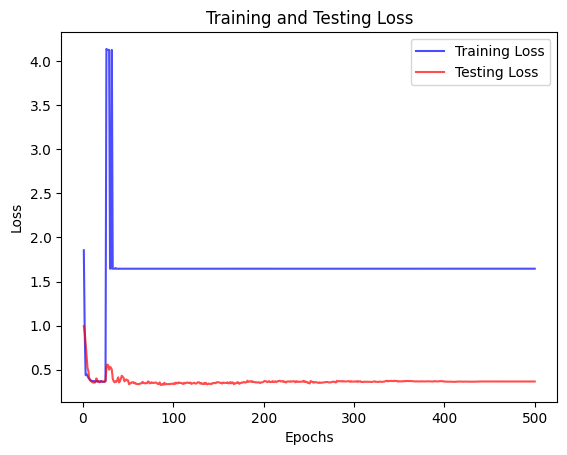

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(test_loss_ls) + 1)
plt.plot(epochs, train_loss_ls, 'b', label='Training Loss', alpha=0.7)
plt.plot(epochs, test_loss_ls, 'r', label='Testing Loss', alpha=0.7)
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()


In [14]:
print(model)

LSTMModel(
  (lstm): LSTM(28, 1024, batch_first=True, bidirectional=True)
)
